## Differentiable Inverse Rendering for BRDF map minification with SlangTorch

In this demo, we will show how one can use BRDFs defined in a shading languages - Slang - together with PyTorch and differentiable Slang for creating appearance-preserving minified BRDF maps.

We will look here at a common and yet surprisingly difficult task in rendering - BRDF minification.
When naively downsampling all BRDF properties, the appearance changes.
Many analytical and approximate models were proposed for common BRDFs, but often operate under fixed assumptions.
We can use differentiable rendering instead to compute properties that match the appearance as close as possible within the model.


### Preliminaries

In the first step, load Python libraries and the textures we will operate on.
For the textures, use only a crop for better display of details in the notebook.

In [1]:
%pip install slangtorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.3/19.3 MB 83.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.8/75.8 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 114.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 86.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 38.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 64.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import cv2
import torch
import slangtorch
import random

In [3]:
# img = cv2.imread(R"diffuse.jpg")[64:64+128,64:64+128,[2,1,0]]/255
# normal = cv2.imread(R"normal.jpg")[64:64+128,64:64+128,[2,1,0]]/255
# roughness = cv2.imread(R"roughness.jpg")[64:64+128,64:64+128,[2,1,0]]/255

# # Square roughness to show more specular highlights for a better visualization.
# roughness *= roughness

# plt.rcParams['figure.figsize'] = (10, 3.3)
# plt.imshow(np.hstack((img, normal, roughness)))
# plt.axis("off")
# plt.show()

### Forward rendering

We have our data loaded and can proceed to render it using Slang.
Slang is a shading language where one programs in a convenient "traditional" SIMT-fashion and can reuse existing rendering codebases, but we can also easily interface with CUDA and PyTorch, which we will do here for easy interaction in Python.

1. Load a SlangTorch kernel.
2. Create SlangTorch input buffer with BRDF properties and in this case, desired lighting vector and view direction.
3. Run the CUDA kernel generated by SlangTorch.
4. Fetch the results to the CPU and display.

In [4]:
!pwd

/content


In [7]:
def display(x):
    return np.clip(2*x, 0, 1)

def grid_size(shape, threads_dim = 16):
    return ((shape[0] + threads_dim - 1)//threads_dim, (shape[1] + threads_dim - 1)//threads_dim, 1)

m = slangtorch.loadModule("lightkernel.slang")

/usr/local/lib/python3.11/dist-packages/torch/utils/cpp_extension.py:2059: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(


In [8]:
# kernel = torch.tensor([
#     [0., 0., 0.],
#     [0., 1., 0.],
#     [0., 0., 0.]
# ]).cuda()
# input_params = (brdf_input_torch.shape[0], brdf_input_torch.shape[1], kernel.shape[0])
# lighting_from_full_res_brdf_2 = torch.zeros(output_shape).cuda()
# m.convolve(input=lighting_from_full_res_brdf,
#        output=lighting_from_full_res_brdf_2,
#         kernel = kernel,
#        input_params=input_params).launchRaw(blockSize=block_size, gridSize=grid_size2)


# plt.rcParams['figure.figsize'] = (6, 6)
# plt.imshow(display(lighting_from_full_res_brdf_2.cpu()))
# plt.axis("off")
# plt.show()

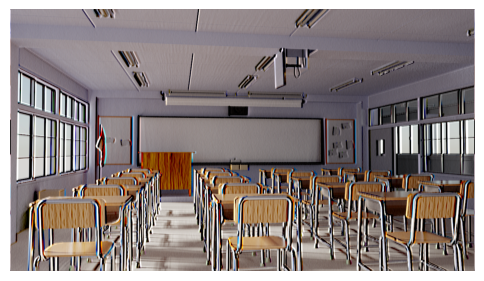

100%|██████████| 40000/40000 [01:53<00:00, 352.67it/s]


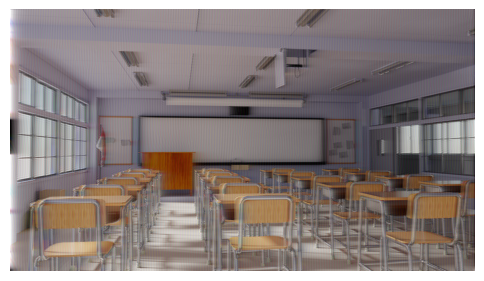

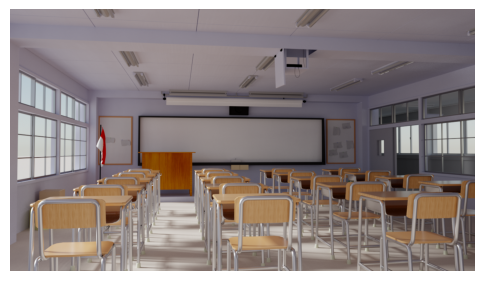

In [33]:
from google.colab.patches import cv2_imshow
import tqdm
def grid_size(shape, threads_dim = 16):
    return ((shape[0] + threads_dim - 1)//threads_dim, (shape[1] + threads_dim - 1)//threads_dim, 1)
img = cv2.imread("./classroom.png")[:,:,[2,1,0]]/255
img_torch = torch.tensor(img, dtype=torch.float32).cuda().contiguous()
block_size = (16, 16, 1)
shap = (img_torch.shape[0], img_torch.shape[1])
grid_size2 = grid_size(shap)
plt.rcParams['figure.figsize'] = (6, 6)
plt.imshow(img_torch.cpu())
plt.axis("off")
plt.show()

kernel = torch.tensor([
[-0.5,-1.0,+0.0,+1.0,+0.5],
[-0.5,+0.0,+0.0,+0.0,+0.5],
[-0.5,+0.0,+1.0,+0.0,+0.5],
[-0.5,+0.0,+0.0,+0.0,+0.5],
[-0.5,-1.0,+0.0,+1.0,+0.5]]).cuda()

empt = torch.zeros_like(img_torch).cuda()
gradient_output = torch.zeros_like(img_torch).cuda()


for i in tqdm.tqdm(range(40000)):
    loss_output = torch.zeros((img_torch.shape[0], img_torch.shape[1], 3)).cuda()
    output_grad = torch.ones_like(loss_output).cuda()

    input_params = (empt.shape[0], empt.shape[1], kernel.shape[0])
    new_empt = torch.zeros_like(empt).cuda()
    m.convolve(input=empt,
               output=new_empt,
               kernel = kernel,
               input_params=input_params).launchRaw(blockSize=block_size, gridSize=grid_size2)
    m.mse_loss.bwd(input=(new_empt, gradient_output),
                                  reference=img_torch,
                                  output=(loss_output, output_grad)).launchRaw(blockSize=block_size, gridSize=grid_size2)
    gradient_output = torch.nan_to_num(gradient_output, 0.0)
    gradient_output = torch.clamp(gradient_output, -1.0, 1.0)
    empt = torch.clip(empt - 0.0001 * gradient_output, 0.0001, 1.0)


plt.rcParams['figure.figsize'] = (6, 6)
plt.imshow(empt.cpu())
plt.axis("off")
plt.show()
img = cv2.imread("./classroom_gt.png")[:,:,[2,1,0]]/255

plt.rcParams['figure.figsize'] = (6, 6)
plt.imshow(img)
plt.axis("off")
plt.show()

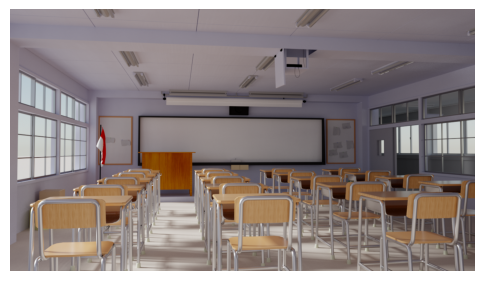